# XGB Model with 9 variables

## Import libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import geopandas as gpd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import os
import copy
import platform
import re
import pandas as pd
import numpy as np
import math
import pickle
from joblib import dump, load
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import f1_score, recall_score, precision_score, brier_score_loss, precision_recall_curve, confusion_matrix, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import bisect 
from scipy.stats import mstats
from xgboost import XGBClassifier
import shap

# specifying constant parameters
random_seed = 5

if platform.uname()[1]=='CD-CQQQRH2':
    working_directory = 'C:\\Users\\oreler\\Documents\\git_repositories\\predicting_hiv_status'
elif platform.uname()[1]=='CL-5BTHZY2':
    working_directory = 'C:\\Users\\oreler\\Documents\\gitlab_repositories\\predicting_hiv_status'
else:
    working_directory = '/home/oreler/predicting_hiv_status'

os.chdir(working_directory)

C:\Users\oreler\Documents\virtualenvs\predicting_hiv_status\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\oreler\Documents\virtualenvs\predicting_hiv_status\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdo

## Load datasets

In [3]:
MR_X_train_entire = pickle.load(open('data/Pure_data/MR_X_train_entire.pkl', 'rb'))
MR_Y_train = pickle.load(open('data/Pure_data/MR_Y_train_entire.pkl', 'rb'))
MR_X_test_entire = pickle.load(open('data/Pure_data/MR_X_test_entire.pkl', 'rb'))
MR_Y_test = pickle.load(open('data/Pure_data/MR_Y_test_entire.pkl', 'rb'))
IR_X_train_entire = pickle.load(open('data/Pure_data/IR_X_train_entire.pkl', 'rb'))
IR_Y_train = pickle.load(open('data/Pure_data/IR_Y_train_entire.pkl', 'rb'))
IR_X_test_entire = pickle.load(open('data/Pure_data/IR_X_test_entire.pkl', 'rb'))
IR_Y_test = pickle.load(open('data/Pure_data/IR_Y_test_entire.pkl', 'rb'))

## Select features

In [4]:
features_9 = ['Cluster\'s latitude coordinate',
              'Current age',
              'Cluster\'s longitude coordinate',
              'Total lifetime number of sex partners',
              'Age of most recent partner',
              'Wealth index factor score combined',
              'Years lived in place of residence',
              'Condom used during last sex with most recent partner',
              'Cluster altitude in meters']

countries = ['Angola',
             'Burundi',
             'Ethiopia',
             'Lesotho',
             'Malawi',
             'Mozambique',
             'Namibia',
             'Rwanda',
             'Zambia',
             'Zimbabwe']

features_9_countries = features_9 + countries

MR_X_train = MR_X_train_entire[features_9]
IR_X_train = IR_X_train_entire[features_9]
MR_X_test = MR_X_test_entire[features_9]
IR_X_test = IR_X_test_entire[features_9]

## Parameters space, models definition and random grid search

In [5]:
# stratified k-fold and model initialization
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
scoring = ['brier_score_loss', 'f1', 'recall', 'precision']

# XGBoost space
params_xgb = {'learning_rate': np.linspace(0, 1, 11),
              'min_split_loss': np.linspace(0, 1, 6),
              'max_depth': np.linspace(2, 10, 5, dtype=int),
              'min_child_weight': np.linspace(1, 20, 20, dtype=int),
              'colsample_bytree': np.linspace(0.5, 1, 6),
              'reg_alpha': np.linspace(0, 1, 11),
              'scale_pos_weight': np.linspace(4, 50, 24, dtype=int),
              'n_estimators': np.linspace(10, 450, 12, dtype=int),
              'reg_lambda': np.linspace(0, 10, 11),
             }

xgb_model_brier = RandomizedSearchCV(estimator=XGBClassifier(booster='gbtree',
                                                       objective='binary:logistic',
                                                       random_state=random_seed,
                                                       nthread=1,
                                                       verbosity=1),
                               param_distributions=params_xgb,
                               n_iter=250,
                               scoring=scoring,
                               cv=kfold,
                               n_jobs=-1,
                               random_state=random_seed,
                               verbose=2,
                               refit='f1')

## Fitting

In [ ]:
xgb_model_brier.fit(MR_X_train.values, MR_Y_train.values)
dump(xgb_model_brier, 'scripts/xgb/MR_xgb_9_brier.joblib')

xgb_model_brier.fit(IR_X_train.values, IR_Y_train.values)
dump(xgb_model_brier, 'scripts/xgb/IR_xgb_9_brier.joblib')

## Load models

In [6]:
MR_model = load('scripts/xgb/MR_xgb_9_brier.joblib')
IR_model = load('scripts/xgb/IR_xgb_9_brier.joblib')

## Probability calibration

In [7]:
MR_calibrated_model = CalibratedClassifierCV(base_estimator=MR_model, method='sigmoid', cv='prefit')
IR_calibrated_model = CalibratedClassifierCV(base_estimator=IR_model, method='sigmoid', cv='prefit')

MR_calibrated_model.fit(MR_X_test.values, MR_Y_test.values)
IR_calibrated_model.fit(IR_X_test.values, IR_Y_test.values)

MR_Y_test_pred_cal = MR_calibrated_model.predict_proba(MR_X_test.values)[:,1]
IR_Y_test_pred_cal = IR_calibrated_model.predict_proba(IR_X_test.values)[:,1]

CalibratedClassifierCV(base_estimator=RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
                                                         error_score='raise-deprecating',
                                                         estimator=XGBClassifier(base_score=0.5,
                                                                                 booster='gbtree',
                                                                                 colsample_bylevel=1,
                                                                                 colsample_bynode=1,
                                                                                 colsample_bytree=1,
                                                                                 gamma=0,
                                                                                 learning_rate=0.1,
                                                                                 max_delta_step=0,
  

CalibratedClassifierCV(base_estimator=RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
                                                         error_score='raise-deprecating',
                                                         estimator=XGBClassifier(base_score=0.5,
                                                                                 booster='gbtree',
                                                                                 colsample_bylevel=1,
                                                                                 colsample_bynode=1,
                                                                                 colsample_bytree=1,
                                                                                 gamma=0,
                                                                                 learning_rate=0.1,
                                                                                 max_delta_step=0,
  

## Results

In [8]:
MR_best_index = MR_model.best_index_
IR_best_index = IR_model.best_index_

print('CV results for Males:')
print('Average F1:', "{:.1%}".format(MR_model.cv_results_['mean_test_f1'][MR_best_index]))
print('CI F1:', "{:.1%}".format(3.104*MR_model.cv_results_['std_test_f1'][MR_best_index]))
print('Average Brier:', "{:.1%}".format(MR_model.cv_results_['mean_test_brier_score_loss'][MR_best_index]))
print('CI Brier:', "{:.1%}".format(3.104*MR_model.cv_results_['std_test_brier_score_loss'][MR_best_index]))
print('Average Sensitivity:', "{:.1%}".format(MR_model.cv_results_['mean_test_recall'][MR_best_index]))
print('CI Sensitivity:', "{:.1%}".format(3.104*MR_model.cv_results_['std_test_recall'][MR_best_index]))
print('Average PPV:', "{:.1%}".format(MR_model.cv_results_['mean_test_precision'][MR_best_index]))
print('CI PPV:', "{:.1%}".format(3.104*MR_model.cv_results_['std_test_precision'][MR_best_index]))
print('CV results for Females:')
print('Average F1:', "{:.1%}".format(IR_model.cv_results_['mean_test_f1'][IR_best_index]))
print('CI F1:', "{:.1%}".format(3.104*IR_model.cv_results_['std_test_f1'][IR_best_index]))
print('Average Brier:', "{:.1%}".format(IR_model.cv_results_['mean_test_brier_score_loss'][IR_best_index]))
print('CI Brier:', "{:.1%}".format(3.104*IR_model.cv_results_['std_test_brier_score_loss'][IR_best_index]))
print('Average Sensitivity:', "{:.1%}".format(IR_model.cv_results_['mean_test_recall'][IR_best_index]))
print('CI Sensitivity:', "{:.1%}".format(3.104*IR_model.cv_results_['std_test_recall'][IR_best_index]))
print('Average PPV:', "{:.1%}".format(IR_model.cv_results_['mean_test_precision'][IR_best_index]))
print('CI PPV:', "{:.1%}".format(3.104*IR_model.cv_results_['std_test_precision'][IR_best_index]))
     
MR_Y_test_pred = MR_model.predict(MR_X_test.values)
IR_Y_test_pred = IR_model.predict(IR_X_test.values)

print('Test results for Males:')
print('Confusion matrix:', confusion_matrix(MR_Y_test, MR_Y_test_pred))
print('F1:', "{:.1%}".format(f1_score(MR_Y_test, MR_Y_test_pred)))
print('Brier:', "{:.1%}".format(brier_score_loss(MR_Y_test, MR_Y_test_pred_cal)))
print('Sensitivity:', "{:.1%}".format(recall_score(MR_Y_test, MR_Y_test_pred)))
print('PPV:', "{:.1%}".format(precision_score(MR_Y_test, MR_Y_test_pred)))
print('Test results for Females:')
print('Confusion matrix:', confusion_matrix(IR_Y_test, IR_Y_test_pred))
print('F1:', "{:.1%}".format(f1_score(IR_Y_test, IR_Y_test_pred)))
print('Brier:', "{:.1%}".format(brier_score_loss(IR_Y_test, IR_Y_test_pred_cal)))
print('Sensitivity:', "{:.1%}".format(recall_score(IR_Y_test, IR_Y_test_pred)))
print('PPV:', "{:.1%}".format(precision_score(IR_Y_test, IR_Y_test_pred)))

CV results for Males:
Average F1: 72.9%
CI F1: 4.6%
Average Brier: -3.3%
CI Brier: 0.5%
Average Sensitivity: 65.6%
CI Sensitivity: 3.1%
Average PPV: 81.9%
CI PPV: 7.7%
CV results for Females:
Average F1: 72.4%
CI F1: 1.9%
Average Brier: -4.8%
CI Brier: 0.5%
Average Sensitivity: 68.5%
CI Sensitivity: 2.8%
Average PPV: 76.8%
CI PPV: 3.3%
Test results for Males:
Confusion matrix: [[10024   124]
 [  288   595]]
F1: 74.3%
Brier: 3.1%
Sensitivity: 67.4%
PPV: 82.8%
Test results for Females:
Confusion matrix: [[12075   249]
 [  418  1184]]
F1: 78.0%
Brier: 3.8%
Sensitivity: 73.9%
PPV: 82.6%


## Function for the sensitivity/PPV curve

In [9]:
def pr_f1_curve(model, X_test, Y_test):
    
    Y_test_predict_proba = model.predict_proba(X_test)[:,1]
    Y_test_predict = model.predict(X_test)
    ppv_curve, sensitivity_curve, _ = precision_recall_curve(Y_test, Y_test_predict_proba)
    F1_score, AUC_score = f1_score(Y_test, Y_test_predict), auc(sensitivity_curve, ppv_curve)
    print(': F1 score = %.3f - Area under Curve = %.3f' % (F1_score, AUC_score))
    prevalence = np.sum(Y_test)/len(Y_test)
    plt.plot([0, 1], [prevalence, prevalence], linestyle='--', label='Random Testing')
    plt.plot(sensitivity_curve, ppv_curve, marker='.', label='Algorithmic Testing')
    plt.plot(sensitivity_curve, 2*(sensitivity_curve*ppv_curve)/(sensitivity_curve+ppv_curve), marker='', label='F1')
    plt.xlabel('Sensitivity')
    plt.ylabel('Positive Predictive Value')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

## Plot curve

: F1 score = 0.741 - Area under Curve = 0.782


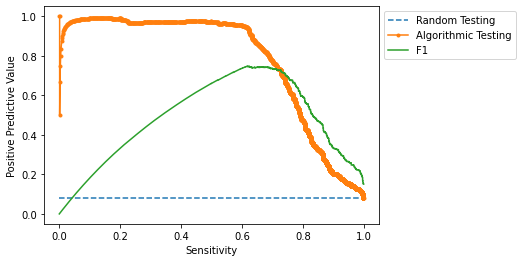

: F1 score = 0.786 - Area under Curve = 0.831


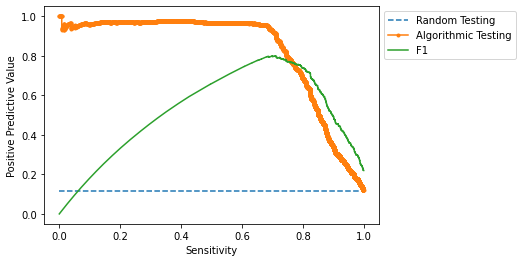

In [10]:
pr_f1_curve(MR_calibrated_model, MR_X_test.values, MR_Y_test.values)
pr_f1_curve(IR_calibrated_model, IR_X_test.values, IR_Y_test.values)

## Plot Shapley values

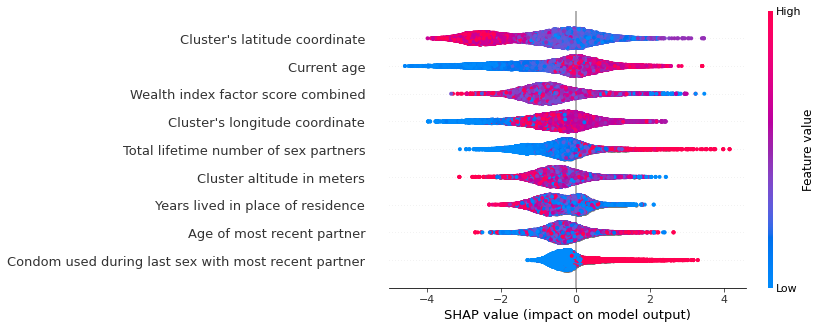

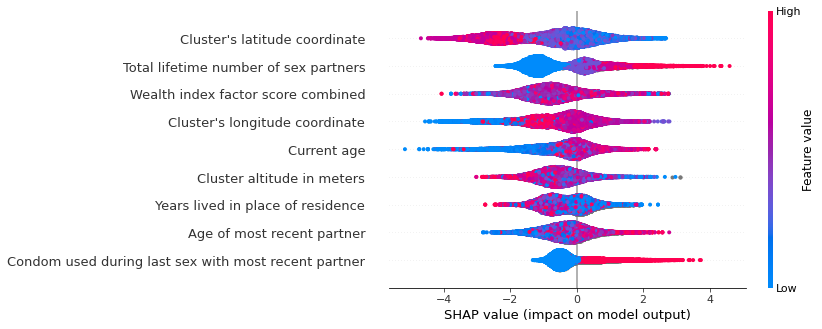

In [57]:
# Explain model predictions using shapley value
MR_explainer = shap.TreeExplainer(MR_model.best_estimator_)
MR_shap_values = MR_explainer.shap_values(MR_X_train)
IR_explainer = shap.TreeExplainer(IR_model.best_estimator_)
IR_shap_values = IR_explainer.shap_values(IR_X_train)

# Plot summary_plot
shap.summary_plot(MR_shap_values, MR_X_train)
shap.summary_plot(IR_shap_values, IR_X_train)

## Scenario 2: Threshold at 90%

### Uncalibrated

In [11]:
MR_Y_test_pred_thresh = (MR_model.predict_proba(MR_X_test.values)[:,1] >= 0.90).astype(bool)
IR_Y_test_pred_thresh = (IR_model.predict_proba(IR_X_test.values)[:,1] >= 0.90).astype(bool)
print('Males')
print(confusion_matrix(MR_Y_test, MR_Y_test_pred_thresh))
print('Females')
print(confusion_matrix(IR_Y_test, IR_Y_test_pred_thresh))

Males
[[10123    25]
 [  357   526]]
Females
[[12276    48]
 [  537  1065]]


### Calibrated

In [12]:
MR_Y_test_pred_thresh_cal = (MR_calibrated_model.predict_proba(MR_X_test.values)[:,1] >= 0.90).astype(bool)
IR_Y_test_pred_thresh_cal = (IR_calibrated_model.predict_proba(IR_X_test.values)[:,1] >= 0.90).astype(bool)
print('Males')
print(confusion_matrix(MR_Y_test, MR_Y_test_pred_thresh_cal))
print('Females')
print(confusion_matrix(IR_Y_test, IR_Y_test_pred_thresh_cal))

Males
[[10128    20]
 [  391   492]]
Females
[[12296    28]
 [  793   809]]


## Scenario 1: Sensitivity of 95%

### Uncalibrated

In [13]:
MR_precision, MR_recall, MR_thresholds = precision_recall_curve(MR_Y_test.values, MR_model.predict_proba(MR_X_test.values)[:,1])
IR_precision, IR_recall, IR_thresholds = precision_recall_curve(IR_Y_test.values, IR_model.predict_proba(IR_X_test.values)[:,1])
MR_f1 = 2*(MR_recall*MR_precision)/(MR_recall+MR_precision)
IR_f1 = 2*(IR_recall*IR_precision)/(IR_recall+IR_precision)

In [14]:
MR_index = np.argmax(MR_precision[(MR_recall >= 0.949999999) & (MR_recall >= 0.9500000001)])
IR_index = np.argmax(IR_precision[(IR_recall >= 0.949999999) & (IR_recall >= 0.9500000001)])
print('Males')
print('F1 score at 95% sensitivity: ', MR_f1[MR_index])
print('Precision at 95% sensitivity: ', MR_precision[MR_index])
print('Threshold at 95% sensitivity: ', MR_thresholds[MR_index])
print('Females')
print('F1 at 95% sensitivity: ', IR_f1[IR_index])
print('Precision at 95% sensitivity: ', IR_precision[IR_index])
print('Threshold at 95% sensitivity: ', IR_thresholds[IR_index])

Males
F1 score at 95% sensitivity:  0.2652771198484131
Precision at 95% sensitivity:  0.15412844036697249
Threshold at 95% sensitivity:  0.0018743522
Females
F1 at 95% sensitivity:  0.3668353820197638
Precision at 95% sensitivity:  0.22729988052568698
Threshold at 95% sensitivity:  0.004782046


In [15]:
MR_Y_test_pred_thresh = (MR_model.predict_proba(MR_X_test.values)[:,1] >= MR_thresholds[MR_index]).astype(bool)
IR_Y_test_pred_thresh = (IR_model.predict_proba(IR_X_test.values)[:,1] >= IR_thresholds[IR_index]).astype(bool)
print('Males')
print(confusion_matrix(MR_Y_test, MR_Y_test_pred_thresh))
print('Females')
print(confusion_matrix(IR_Y_test, IR_Y_test_pred_thresh))

Males
[[5538 4610]
 [  43  840]]
Females
[[7150 5174]
 [  80 1522]]


### Calibrated

In [16]:
MR_precision, MR_recall, MR_thresholds = precision_recall_curve(MR_Y_test.values, MR_calibrated_model.predict_proba(MR_X_test.values)[:,1])
IR_precision, IR_recall, IR_thresholds = precision_recall_curve(IR_Y_test.values, IR_calibrated_model.predict_proba(IR_X_test.values)[:,1])
MR_f1 = 2*(MR_recall*MR_precision)/(MR_recall+MR_precision)
IR_f1 = 2*(IR_recall*IR_precision)/(IR_recall+IR_precision)

In [17]:
MR_index = np.argmax(MR_precision[(MR_recall >= 0.949999999) & (MR_recall >= 0.9500000001)])
IR_index = np.argmax(IR_precision[(IR_recall >= 0.949999999) & (IR_recall >= 0.9500000001)])
print('Males')
print('F1 score at 95% sensitivity: ', MR_f1[MR_index])
print('Precision at 95% sensitivity: ', MR_precision[MR_index])
print('Threshold at 95% sensitivity: ', MR_thresholds[MR_index])
print('Females')
print('F1 at 95% sensitivity: ', IR_f1[IR_index])
print('Precision at 95% sensitivity: ', IR_precision[IR_index])
print('Threshold at 95% sensitivity: ', IR_thresholds[IR_index])

Males
F1 score at 95% sensitivity:  0.2652771198484131
Precision at 95% sensitivity:  0.15412844036697249
Threshold at 95% sensitivity:  0.0213018711656332
Females
F1 at 95% sensitivity:  0.3668353820197638
Precision at 95% sensitivity:  0.22729988052568698
Threshold at 95% sensitivity:  0.022904423996806145


In [18]:
MR_Y_test_pred_thresh = (MR_calibrated_model.predict_proba(MR_X_test.values)[:,1] >= MR_thresholds[MR_index]).astype(bool)
IR_Y_test_pred_thresh = (IR_calibrated_model.predict_proba(IR_X_test.values)[:,1] >= IR_thresholds[IR_index]).astype(bool)
print('Males')
print(confusion_matrix(MR_Y_test, MR_Y_test_pred_thresh))
print('Females')
print(confusion_matrix(IR_Y_test, IR_Y_test_pred_thresh))

Males
[[5538 4610]
 [  43  840]]
Females
[[7150 5174]
 [  80 1522]]


## Calibration Curve

[<matplotlib.lines.Line2D at 0x18a8e5e85c8>]

[<matplotlib.lines.Line2D at 0x18a8e5e8b88>]

[<matplotlib.lines.Line2D at 0x18a8dadac08>]

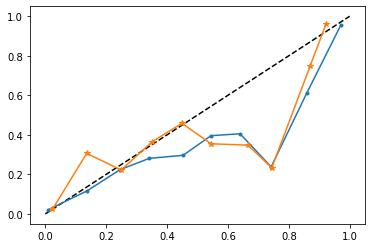

In [19]:
fop_uncalibrated, mpv_uncalibrated = calibration_curve(MR_Y_test.values, MR_model.predict_proba(MR_X_test.values)[:,1], n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(MR_Y_test.values, MR_calibrated_model.predict_proba(MR_X_test.values)[:,1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.')
plt.plot(mpv_calibrated, fop_calibrated, marker='*')
plt.show()

## Prediction per Country

In [20]:
MR_X_train_country = MR_X_train_entire[features_9_countries]
IR_X_train_country = IR_X_train_entire[features_9_countries]
MR_X_test_country = MR_X_test_entire[features_9_countries]
IR_X_test_country = IR_X_test_entire[features_9_countries]

### Male

In [21]:
MR_results_country = {}

for country in countries:
    MR_results_country[country] = []
    print('Male')
    print(country + ': test dataset prevalence is ' + "{:.1%}".format(MR_Y_test[MR_X_test_country[country]==1].mean()) + ' vs ' + "{:.1%}".format(MR_Y_test_pred[MR_X_test_country[country]==1].mean()) + ' for the predicted')
    MR_results_country[country].append(MR_Y_test_pred[MR_X_test_country[country]==1].mean())
    rel_diff = (MR_Y_test_pred[MR_X_test_country[country]==1].mean()-MR_Y_test[MR_X_test_country[country]==1].mean())/MR_Y_test[MR_X_test_country[country]==1].mean()
    MR_results_country[country].append(rel_diff)
    abs_diff = (MR_Y_test_pred[MR_X_test_country[country]==1].mean()-MR_Y_test[MR_X_test_country[country]==1].mean())
    MR_results_country[country].append(abs_diff)
    print('Relative difference: ' + "{:.1%}".format(rel_diff))
    print('Absolute difference: ' + "{:.1%}".format(abs_diff))

Male
Angola: test dataset prevalence is 1.4% vs 1.0% for the predicted
Relative difference: -30.8%
Absolute difference: -0.4%
Male
Burundi: test dataset prevalence is 0.5% vs 0.4% for the predicted
Relative difference: -20.0%
Absolute difference: -0.1%
Male
Ethiopia: test dataset prevalence is 1.0% vs 0.7% for the predicted
Relative difference: -31.2%
Absolute difference: -0.3%
Male
Lesotho: test dataset prevalence is 20.7% vs 18.2% for the predicted
Relative difference: -12.1%
Absolute difference: -2.5%
Male
Malawi: test dataset prevalence is 6.6% vs 4.4% for the predicted
Relative difference: -32.9%
Absolute difference: -2.2%
Male
Mozambique: test dataset prevalence is 11.2% vs 9.4% for the predicted
Relative difference: -16.3%
Absolute difference: -1.8%
Male
Namibia: test dataset prevalence is 12.0% vs 10.0% for the predicted
Relative difference: -16.0%
Absolute difference: -1.9%
Male
Rwanda: test dataset prevalence is 3.1% vs 2.1% for the predicted
Relative difference: -32.1%
Absol

### Female

In [22]:
IR_results_country = {}

for country in countries:
    IR_results_country[country] = []
    print('Male')
    print(country + ': test dataset prevalence is ' + "{:.1%}".format(IR_Y_test[IR_X_test_country[country]==1].mean()) + ' vs ' + "{:.1%}".format(IR_Y_test_pred[IR_X_test_country[country]==1].mean()) + ' for the predicted')
    IR_results_country[country].append(IR_Y_test_pred[IR_X_test_country[country]==1].mean())
    rel_diff = (IR_Y_test_pred[IR_X_test_country[country]==1].mean()-IR_Y_test[IR_X_test_country[country]==1].mean())/IR_Y_test[IR_X_test_country[country]==1].mean()
    IR_results_country[country].append(rel_diff)
    abs_diff = (IR_Y_test_pred[IR_X_test_country[country]==1].mean()-IR_Y_test[IR_X_test_country[country]==1].mean())
    IR_results_country[country].append(abs_diff)
    print('Relative difference: ' + "{:.1%}".format(rel_diff))
    print('Absolute difference: ' + "{:.1%}".format(abs_diff))

Male
Angola: test dataset prevalence is 2.8% vs 1.9% for the predicted
Relative difference: -33.3%
Absolute difference: -0.9%
Male
Burundi: test dataset prevalence is 1.4% vs 1.1% for the predicted
Relative difference: -23.5%
Absolute difference: -0.3%
Male
Ethiopia: test dataset prevalence is 1.7% vs 1.2% for the predicted
Relative difference: -27.0%
Absolute difference: -0.5%
Male
Lesotho: test dataset prevalence is 33.1% vs 32.6% for the predicted
Relative difference: -1.5%
Absolute difference: -0.5%
Male
Malawi: test dataset prevalence is 13.1% vs 10.8% for the predicted
Relative difference: -17.9%
Absolute difference: -2.3%
Male
Mozambique: test dataset prevalence is 16.1% vs 13.7% for the predicted
Relative difference: -15.0%
Absolute difference: -2.4%
Male
Namibia: test dataset prevalence is 21.3% vs 19.2% for the predicted
Relative difference: -9.7%
Absolute difference: -2.1%
Male
Rwanda: test dataset prevalence is 4.5% vs 4.0% for the predicted
Relative difference: -10.9%
Abso

## Metrics per country

### Male

In [23]:
for country in countries:
    
    print(country)
    print('Test results for Males:')
    print('Confusion matrix:', confusion_matrix(MR_Y_test[MR_X_test_country[country]==1], MR_Y_test_pred[MR_X_test_country[country]==1]))
    print('F1:', "{:.1%}".format(f1_score(MR_Y_test[MR_X_test_country[country]==1], MR_Y_test_pred[MR_X_test_country[country]==1])))
    print('Brier:', "{:.1%}".format(brier_score_loss(MR_Y_test[MR_X_test_country[country]==1], MR_Y_test_pred_cal[MR_X_test_country[country]==1])))
    print('Sensitivity:', "{:.1%}".format(recall_score(MR_Y_test[MR_X_test_country[country]==1], MR_Y_test_pred[MR_X_test_country[country]==1])))
    print('PPV:', "{:.1%}".format(precision_score(MR_Y_test[MR_X_test_country[country]==1], MR_Y_test_pred[MR_X_test_country[country]==1])))

Angola
Test results for Males:
Confusion matrix: [[898   0]
 [  4   9]]
F1: 81.8%
Brier: 0.5%
Sensitivity: 69.2%
PPV: 100.0%
Burundi
Test results for Males:
Confusion matrix: [[1049    1]
 [   2    3]]
F1: 66.7%
Brier: 0.3%
Sensitivity: 60.0%
PPV: 75.0%
Ethiopia
Test results for Males:
Confusion matrix: [[1510    0]
 [   5   11]]
F1: 81.5%
Brier: 0.4%
Sensitivity: 68.8%
PPV: 100.0%
Lesotho
Test results for Males:
Confusion matrix: [[398  12]
 [ 25  82]]
F1: 81.6%
Brier: 6.3%
Sensitivity: 76.6%
PPV: 87.2%
Malawi
Test results for Males:
Confusion matrix: [[1063   12]
 [  37   39]]
F1: 61.4%
Brier: 3.2%
Sensitivity: 51.3%
PPV: 76.5%
Mozambique
Test results for Males:
Confusion matrix: [[720  11]
 [ 26  66]]
F1: 78.1%
Brier: 3.8%
Sensitivity: 71.7%
PPV: 85.7%
Namibia
Test results for Males:
Confusion matrix: [[540  12]
 [ 24  51]]
F1: 73.9%
Brier: 4.8%
Sensitivity: 68.0%
PPV: 81.0%
Rwanda
Test results for Males:
Confusion matrix: [[884   4]
 [ 13  15]]
F1: 63.8%
Brier: 1.7%
Sensitivity: 53

### Female

In [24]:
for country in countries:
    
    print(country)
    print('Test results for Males:')
    print('Confusion matrix:', confusion_matrix(IR_Y_test[IR_X_test_country[country]==1], IR_Y_test_pred[IR_X_test_country[country]==1]))
    print('F1:', "{:.1%}".format(f1_score(IR_Y_test[IR_X_test_country[country]==1], IR_Y_test_pred[IR_X_test_country[country]==1])))
    print('Brier:', "{:.1%}".format(brier_score_loss(IR_Y_test[IR_X_test_country[country]==1], IR_Y_test_pred_cal[IR_X_test_country[country]==1])))
    print('Sensitivity:', "{:.1%}".format(recall_score(IR_Y_test[IR_X_test_country[country]==1], IR_Y_test_pred[IR_X_test_country[country]==1])))
    print('PPV:', "{:.1%}".format(precision_score(IR_Y_test[IR_X_test_country[country]==1], IR_Y_test_pred[IR_X_test_country[country]==1])))

Angola
Test results for Males:
Confusion matrix: [[1124    5]
 [  16   17]]
F1: 61.8%
Brier: 1.6%
Sensitivity: 51.5%
PPV: 77.3%
Burundi
Test results for Males:
Confusion matrix: [[1193    1]
 [   5   12]]
F1: 80.0%
Brier: 0.5%
Sensitivity: 70.6%
PPV: 92.3%
Ethiopia
Test results for Males:
Confusion matrix: [[2170    4]
 [  14   23]]
F1: 71.9%
Brier: 0.7%
Sensitivity: 62.2%
PPV: 85.2%
Lesotho
Test results for Males:
Confusion matrix: [[363  38]
 [ 41 157]]
F1: 79.9%
Brier: 10.2%
Sensitivity: 79.3%
PPV: 80.5%
Malawi
Test results for Males:
Confusion matrix: [[1165   19]
 [  51  128]]
F1: 78.5%
Brier: 4.2%
Sensitivity: 71.5%
PPV: 87.1%
Mozambique
Test results for Males:
Confusion matrix: [[1042   32]
 [  63  143]]
F1: 75.1%
Brier: 5.8%
Sensitivity: 69.4%
PPV: 81.7%
Namibia
Test results for Males:
Confusion matrix: [[657  27]
 [ 45 140]]
F1: 79.5%
Brier: 6.4%
Sensitivity: 75.7%
PPV: 83.8%
Rwanda
Test results for Males:
Confusion matrix: [[962   9]
 [ 14  32]]
F1: 73.6%
Brier: 1.8%
Sensitiv

## Africa Map

### Install geopandas dependencies for Windows

In [ ]:
%pip install "C:\Users\oreler\Downloads\GDAL-3.3.2-cp37-cp37m-win_amd64.whl"
%pip install "C:\Users\oreler\Downloads\Fiona-1.8.20-cp37-cp37m-win_amd64.whl"
%pip install geopandas

In [ ]:
%pip install "C:\Users\oreler\Downloads\Cartopy-0.20.0-cp37-cp37m-win_amd64.whl"

### Create DataFrame

In [25]:
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa_map = world_map[world_map.continent == 'Africa']
africa_map.reset_index(drop=True, inplace=True)
africa_map.drop(['pop_est', 'gdp_md_est', 'continent'], axis=1, inplace=True)
africa_map['predicted_prevalence'] = np.nan
africa_map['relative_difference'] = np.nan
africa_map['absolute_difference'] = np.nan

MR_africa_map = copy.deepcopy(africa_map)
IR_africa_map = copy.deepcopy(africa_map)

for country in countries:
    
    MR_africa_map['predicted_prevalence'].loc[MR_africa_map['name']==country] = MR_results_country[country][0]
    IR_africa_map['predicted_prevalence'].loc[IR_africa_map['name']==country] = IR_results_country[country][0]
    
    MR_africa_map['relative_difference'].loc[MR_africa_map['name']==country] = MR_results_country[country][1]
    IR_africa_map['relative_difference'].loc[IR_africa_map['name']==country] = IR_results_country[country][1]
    
    MR_africa_map['absolute_difference'].loc[MR_africa_map['name']==country] = MR_results_country[country][2]
    IR_africa_map['absolute_difference'].loc[IR_africa_map['name']==country] = IR_results_country[country][2]
 

In [26]:
dump(MR_africa_map, 'scripts/xgb/MR_africa_map.joblib')
dump(IR_africa_map, 'scripts/xgb/IR_africa_map.joblib')

from mpl_toolkits.axes_grid1 import make_axes_locatable

['scripts/xgb/MR_africa_map.joblib']

['scripts/xgb/IR_africa_map.joblib']

In [27]:
MR = copy.deepcopy(MR_africa_map)
IR = copy.deepcopy(IR_africa_map)

In [28]:
country_rm = ["Morocco", "Libya","Egypt","Tunisia","Mauritania","Mali","Niger","Chad","Sudan","Senegal","Guinea","Côte d'Ivoire","Liberia","Burkina Faso","Ghana", "Togo","Benin","Sierra Leone",
             "Algeria", "Madagascar", "W. Sahara", "Nigeria", "Guinea-Bissau", "Gambia"]
#for men
MR = MR[~MR['name'].isin(country_rm)]
MR["absolute_difference"]=MR["absolute_difference"]*100
MR["predicted_prevalence"]=MR["predicted_prevalence"]*100
#for woman
IR = IR[~IR['name'].isin(country_rm)]
IR["absolute_difference"]=IR["absolute_difference"]*100
IR["predicted_prevalence"]=IR["predicted_prevalence"]*100

### Plot map

### Male

<AxesSubplot:>

<AxesSubplot:>

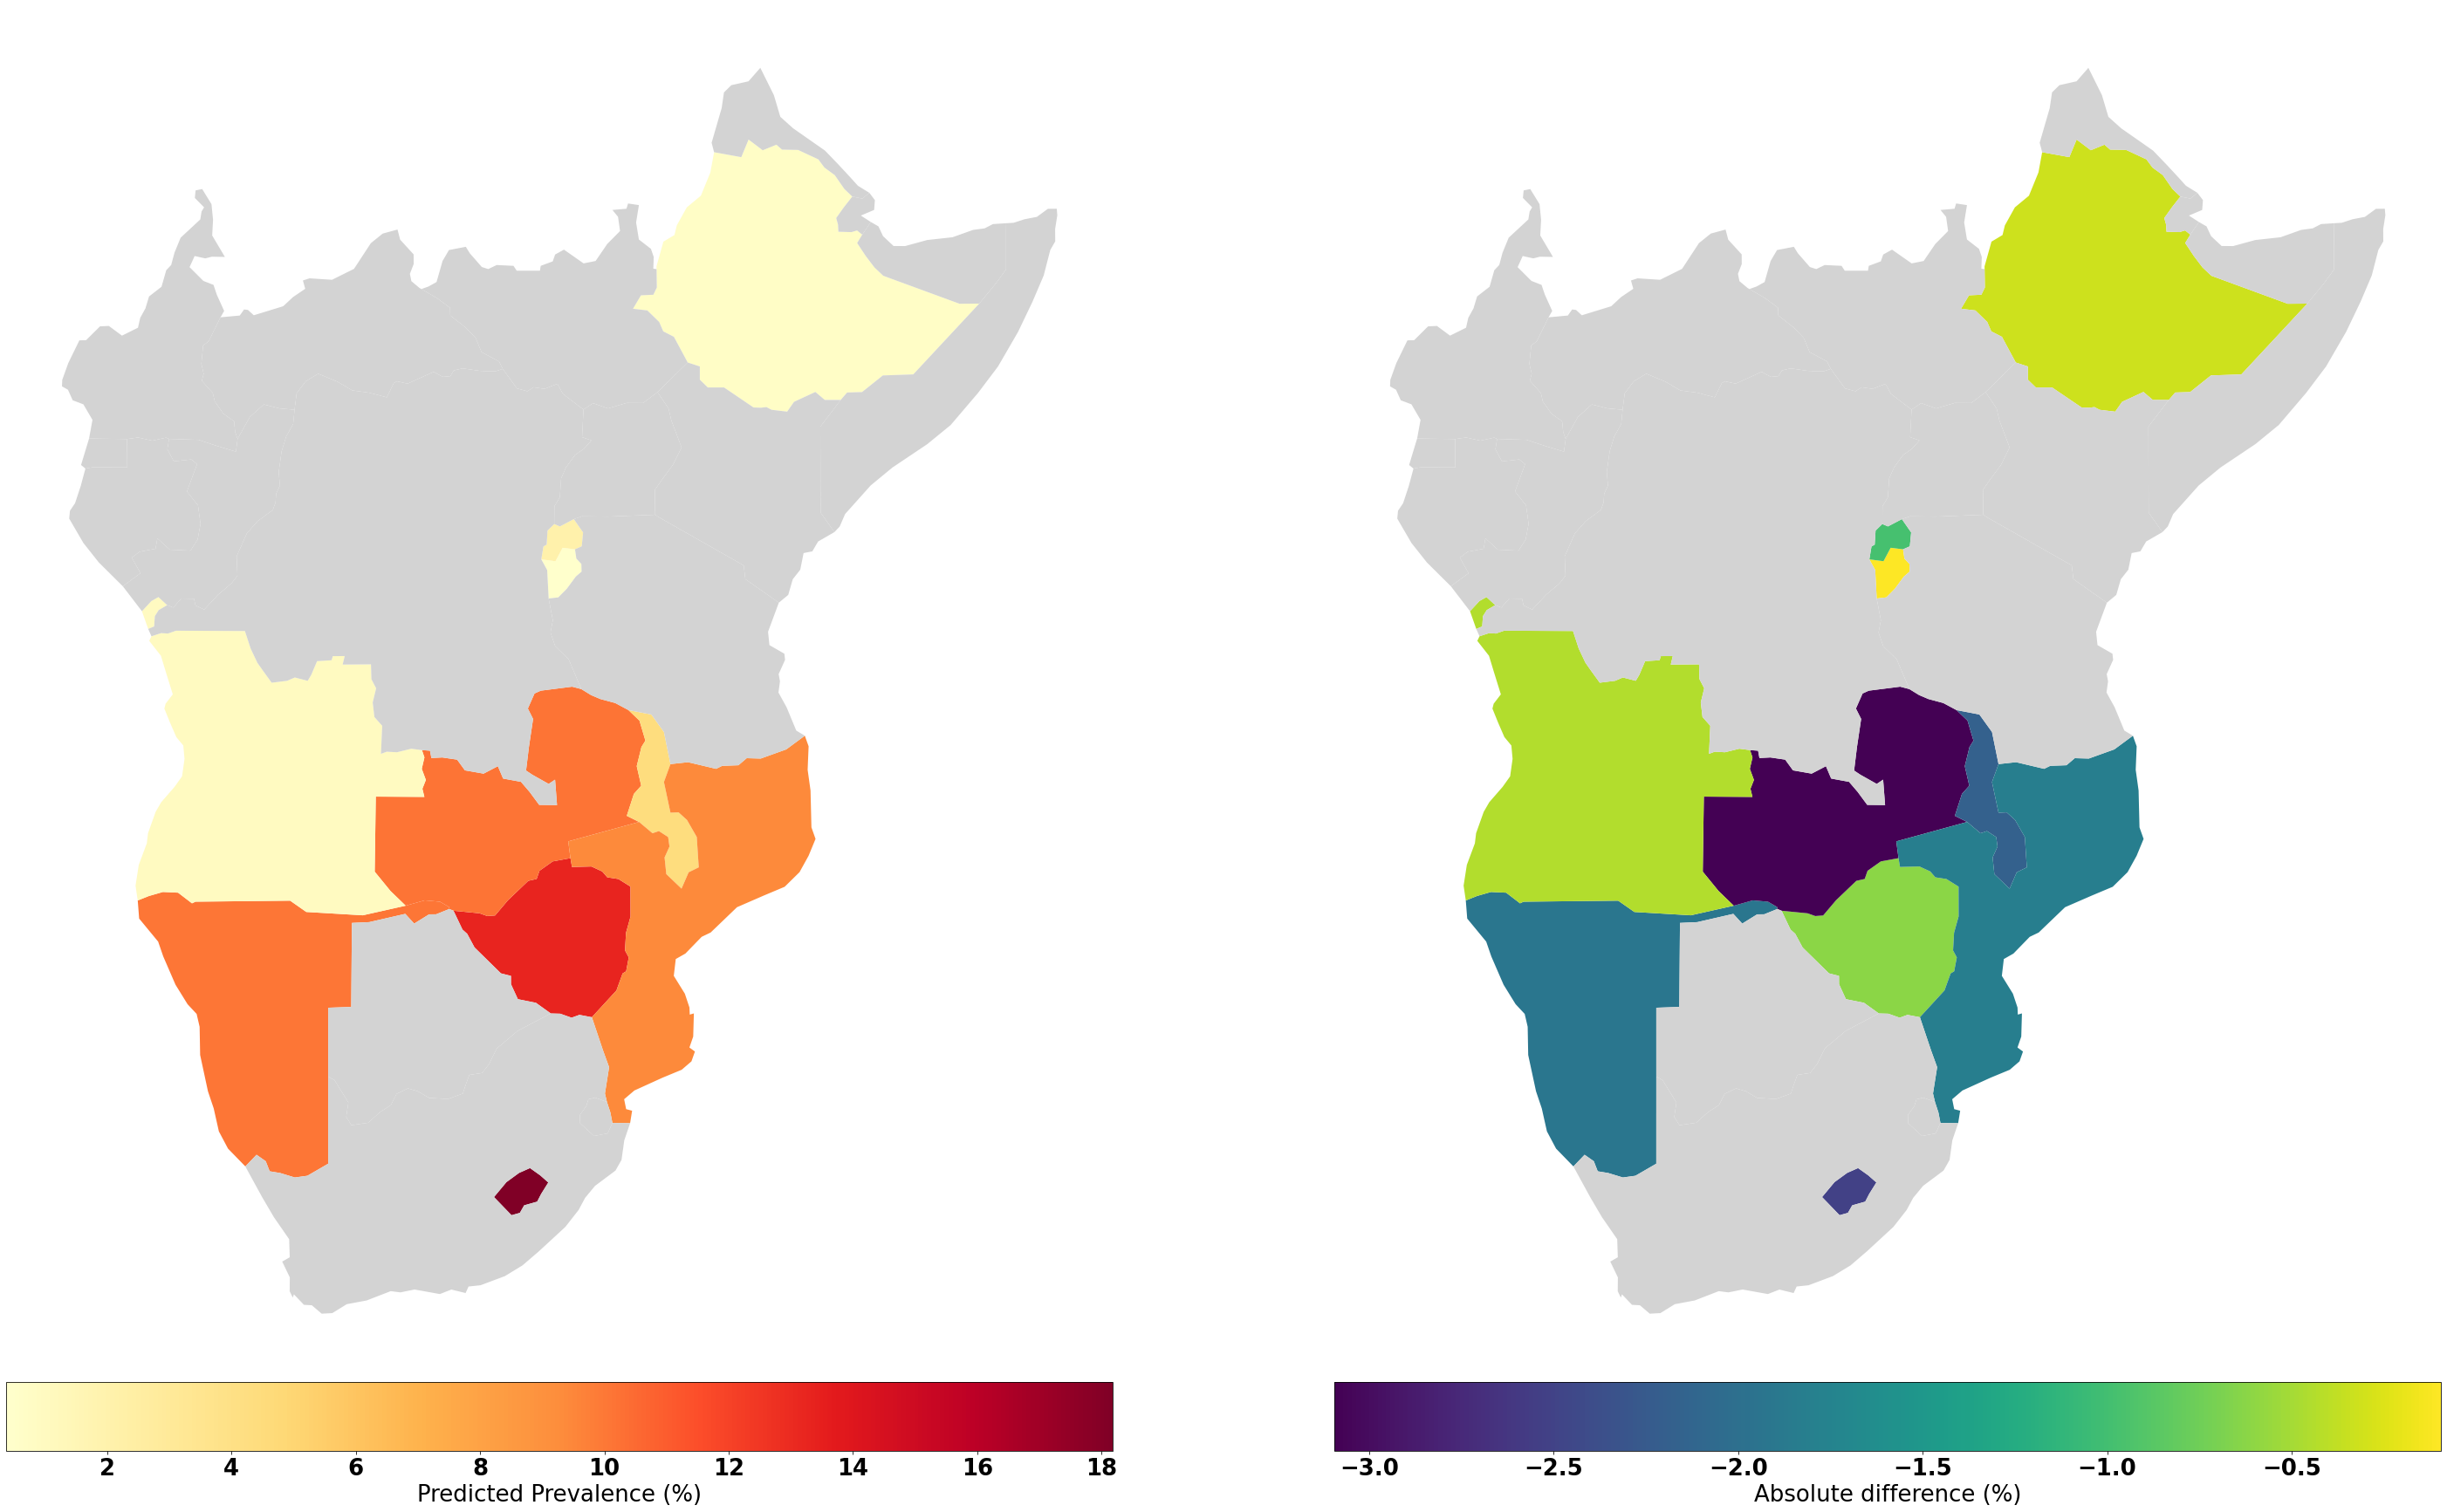

In [29]:
plt.close()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(50,50))
fig.patch.set_facecolor('white')
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 26}

plt.rc('font', **font)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom",size="5%", pad=0.1)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom",size="5%", pad=0.1)

MR.plot(ax=ax1,
                   cmap = 'YlOrRd',
                   column='predicted_prevalence',
                   legend=True,
                   legend_kwds={'label': "Predicted Prevalence (%)",
                                'orientation': "horizontal",
                               'cax': cax1,
                               'pad': 0.01},
                   missing_kwds={'color': 'lightgrey'}
                  )

MR.plot(ax=ax2,
                   cmap = 'viridis',
                   column='absolute_difference',
                   legend=True,
                   legend_kwds={'label': "Absolute difference (%)",
                                'orientation': "horizontal",
                                'cax': cax2,
                                'pad': 0.01},
                   missing_kwds={'color': 'lightgrey'}
                  )

ax1.set_axis_off();
ax2.set_axis_off();
#ax1.set_xlabel('Longitude')
#ax1.set_ylabel('Latitude')
#ax2.set_xlabel('Longitude')
#ax2.set_ylabel('Latitude')
fig.savefig('MR_map.png', bbox_inches='tight', transparent=True, facecolor=fig.get_facecolor(), edgecolor='none')

<AxesSubplot:>

<AxesSubplot:>

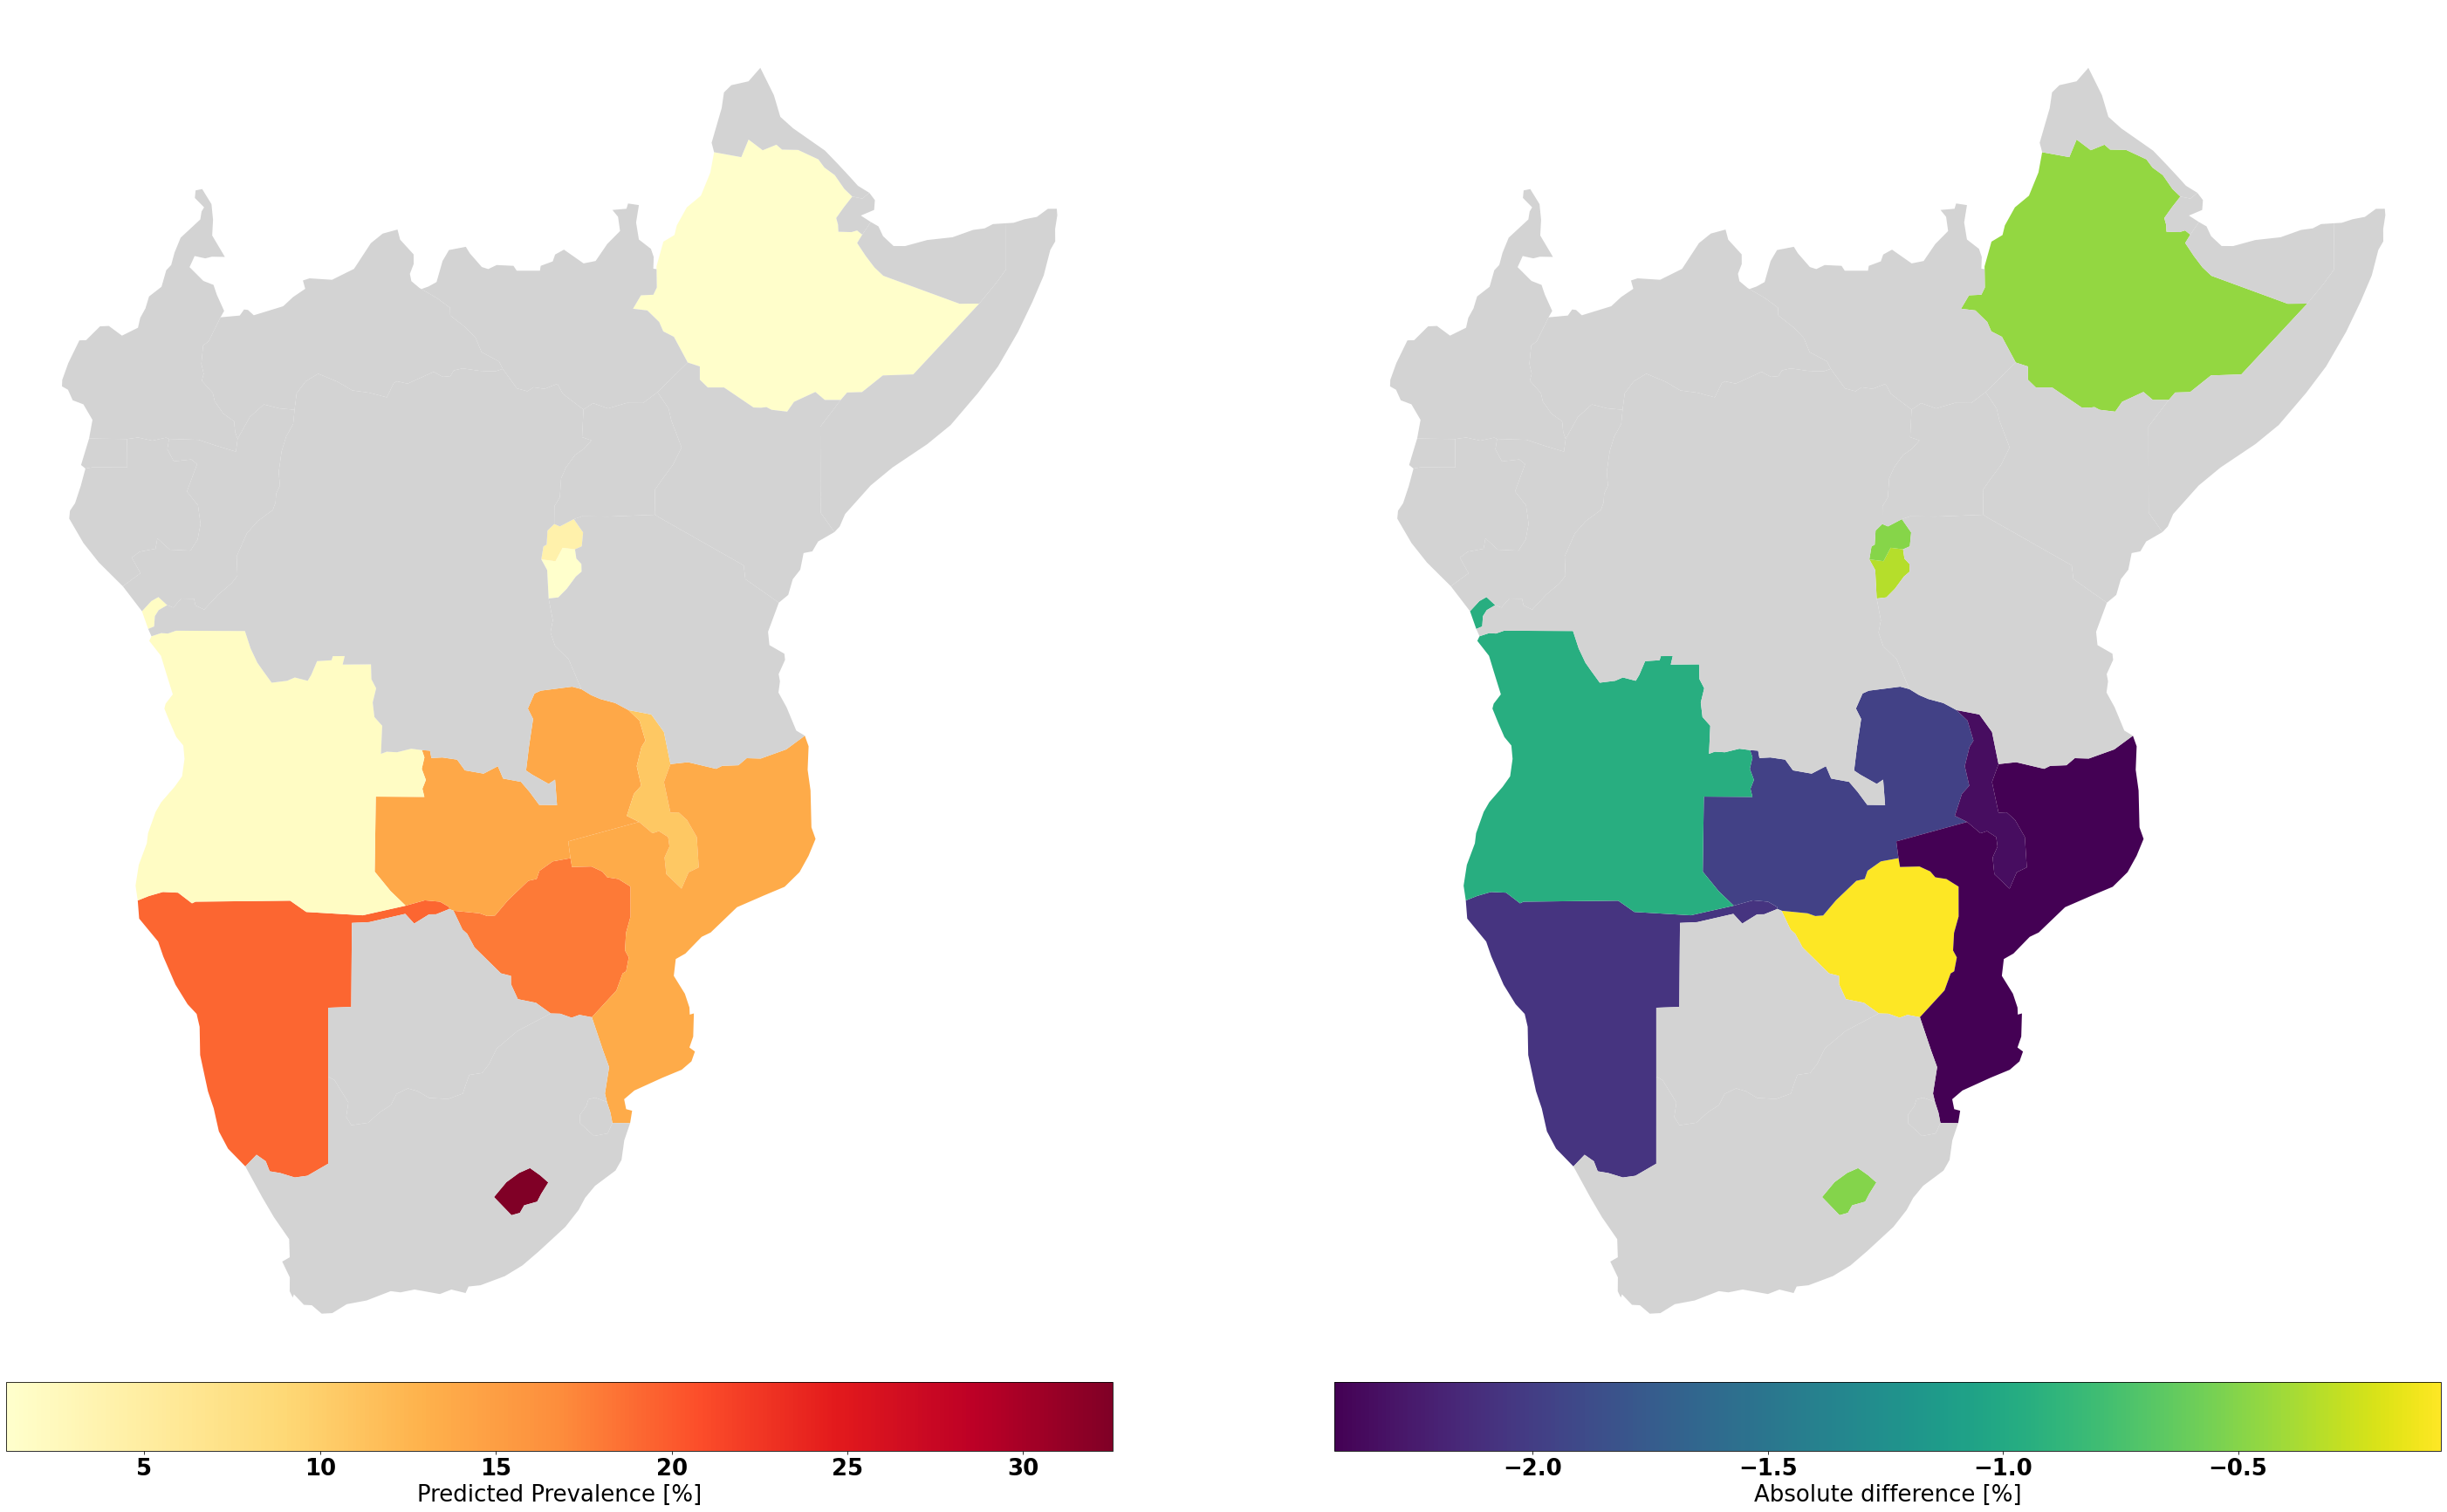

In [30]:
plt.close()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(50,50))
fig.patch.set_facecolor('white')
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 26}

plt.rc('font', **font)
divider1 = make_axes_locatable(ax1)
cax = divider1.append_axes("bottom",size="5%", pad=0.1)
divider2 = make_axes_locatable(ax2)
cax1 = divider2.append_axes("bottom",size="5%", pad=0.1)
IR.plot(ax=ax1,
                   cmap = 'YlOrRd',
                   column='predicted_prevalence',
                   legend=True,
                   legend_kwds={'label': "Predicted Prevalence [%]",
                                'orientation': "horizontal",
                                 'cax':cax,
                                 'pad': 0.01},
        
                   missing_kwds={'color': 'lightgrey'}
                  )

IR.plot(ax=ax2,
                   cmap = 'viridis',
                   column='absolute_difference',
                   legend=True,
                   legend_kwds={'label': "Absolute difference [%]",
                                'orientation': "horizontal",
                                 'cax':cax1,
                                 'pad': 0.01},
                   missing_kwds={'color': 'lightgrey'}
                  )
ax1.set_axis_off();
ax2.set_axis_off();
plt.show()
fig.savefig('IR_map.png', bbox_inches='tight', transparent=True,facecolor=fig.get_facecolor(), edgecolor='none')

## Garbage to clean

In [ ]:
MR_xgb_selected.best_estimator_.get_booster().feature_names

In [100]:
MR_sfs_pure = load("MR_sfs_pure.joblib")

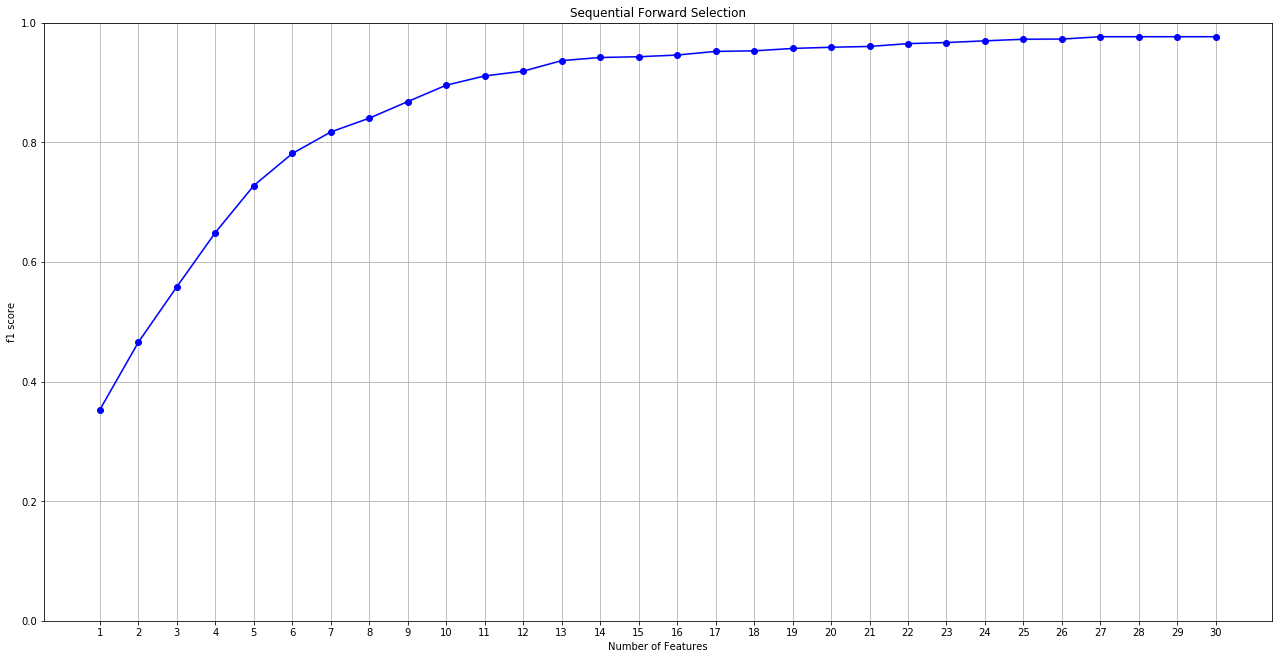

In [98]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(IR_sfs_pure.get_metric_dict(),
                kind='std_dev',
                figsize=(22, 11))

plt.ylim([0, 1])
plt.ylabel('f1 score')
plt.title('Sequential Forward Selection')
plt.grid()
plt.show

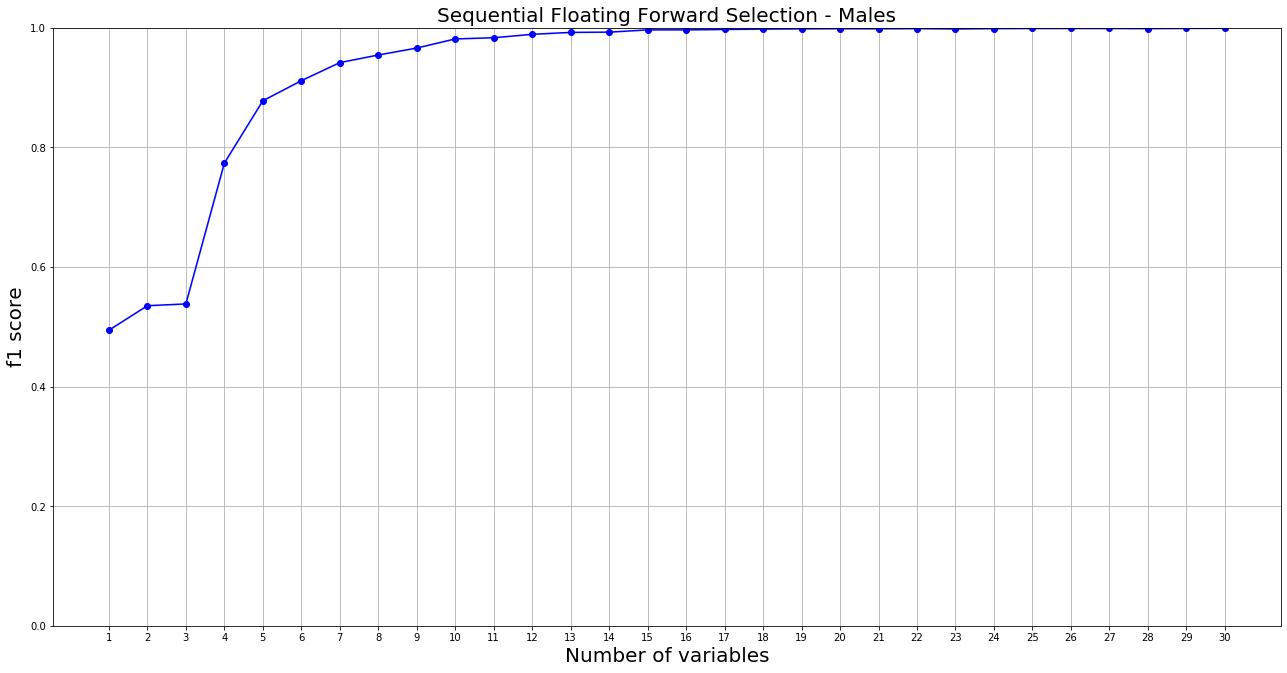

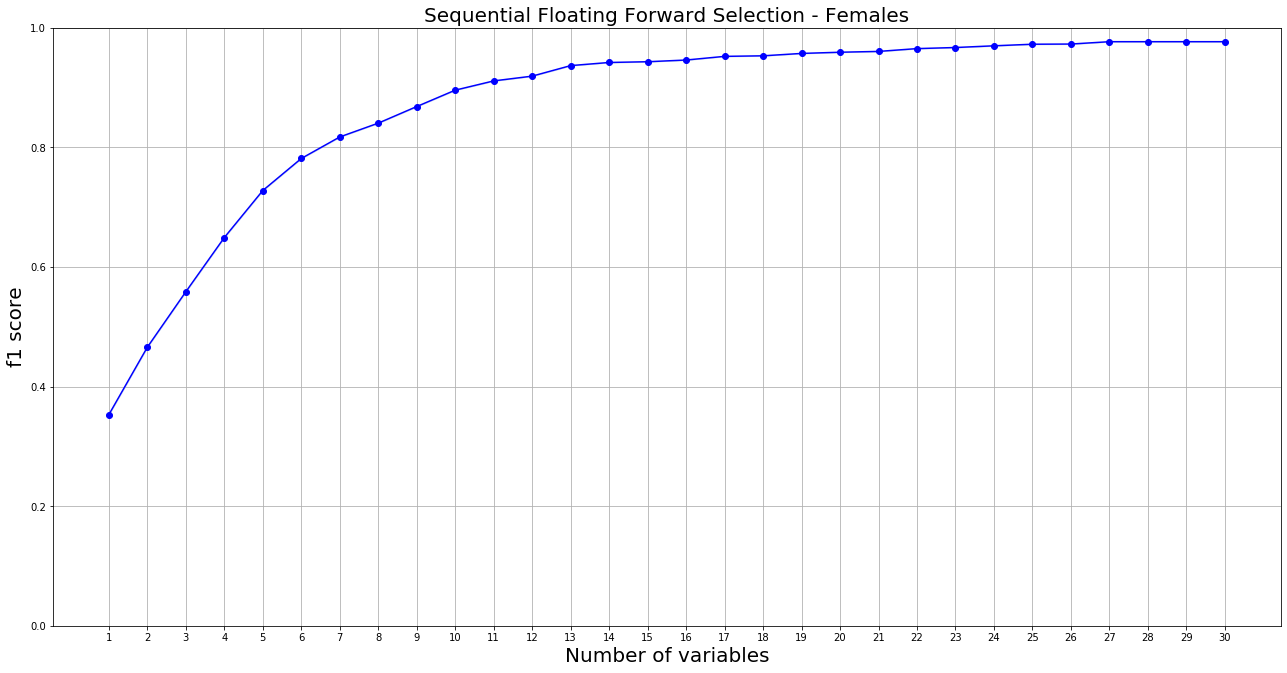

In [175]:
%matplotlib inline
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

plot_sfs(MR_sfs_pure.get_metric_dict(),
                kind='std_dev',
                figsize=(22, 11))

plt.ylim([0, 1])
plt.xlabel('Number of variables', fontsize=20)
plt.ylabel('f1 score', fontsize=20)
plt.title('Sequential Floating Forward Selection - Males', fontsize=20)
plt.grid()
plt.savefig('MR_sfs.jpg')

plot_sfs(IR_sfs_pure.get_metric_dict(),
                kind='std_dev',
                figsize=(22, 11))

plt.ylim([0, 1])
plt.xlabel('Number of variables', fontsize=20)
plt.ylabel('f1 score', fontsize=20)
plt.title('Sequential Floating Forward Selection - Females', fontsize=20)
plt.grid()
plt.savefig('IR_sfs.jpg')